In [289]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
files.upload()
import pandas as pd


In [290]:
df = pd.read_csv("desafio_indicium_imdb.csv")

In [291]:
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [292]:
df['Gross'] = df['Gross'].str.replace(',', '', regex=True)
df['Gross'] = pd.to_numeric(df['Gross'])
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=True)
df['Runtime'] = pd.to_numeric(df['Runtime'])
df['Certificate'].fillna(df['Certificate'].mode()[0], inplace=True)
df['Meta_score'].fillna(df['Meta_score'].mean(), inplace=True)
df['Gross'].fillna(df['Gross'].mean(), inplace=True)

/tmp/ipython-input-2645077637.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Certificate'].fillna(df['Certificate'].mode()[0], inplace=True)
/tmp/ipython-input-2645077637.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [293]:
def preprocess_movies_basic(df):
    df = df.copy()


    if "Gross" in df.columns:
        df["Gross"] = df["Gross"].astype(str).str.replace(",", "", regex=True)
        df["Gross"] = pd.to_numeric(df["Gross"], errors="coerce")
        df["Gross"] = df["Gross"].fillna(df["Gross"].mean())

    if "Runtime" in df.columns:
        df["Runtime"] = df["Runtime"].astype(str).str.replace(" min", "", regex=True)
        df["Runtime"] = pd.to_numeric(df["Runtime"], errors="coerce")
        df["Runtime"] = df["Runtime"].fillna(df["Runtime"].mean())

    if "Certificate" in df.columns:
        df["Certificate"] = df["Certificate"].fillna(df["Certificate"].mode()[0])

    if "Meta_score" in df.columns:
        df["Meta_score"] = df["Meta_score"].fillna(df["Meta_score"].mean())


    cat_features = ["Director", "Star1", "Star2", "Star3", "Star4", "Certificate", "Released_Year"]
    for col in cat_features:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: ", ".join(map(str, x)) if isinstance(x, list) else str(x))

    if "Released_Year" in df.columns:
        df["Released_Year"] = df["Released_Year"].astype(str)

    return df


In [294]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

def process_genre(df, mlb=None, fit_mlb=False):
    df = df.copy()

    if "Genre" not in df.columns:
        return df, mlb

    df["Genre_split"] = df["Genre"].apply(lambda x: [g.strip() for g in str(x).split(",")])

    if fit_mlb:
        mlb = MultiLabelBinarizer()
        genre_encoded = mlb.fit_transform(df["Genre_split"])
    else:
        if mlb is None:
            raise ValueError("mlb must be provided when fit_mlb=False")
        genre_encoded = mlb.transform(df["Genre_split"])

    genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df.index)

    df = pd.concat([df.drop(columns=["Genre", "Genre_split"]), genre_df], axis=1)

    return df, mlb


In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    999 non-null    object 
 4   Runtime        999 non-null    int64  
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     999 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          999 non-null    float64
dtypes: float64(3), int64(3), object(10)
memory usage: 125.0+ KB


Acima, foi realizado o tratamento dos dados, para que fique uniforme.

In [296]:
top_directors = df['Director'].value_counts().head(10).index
df_top_directors = df[df['Director'].isin(top_directors)]

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns

Acima, importamos as biblíotecas necessárias para a criação de gráficos.

In [298]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

/tmp/ipython-input-1543290752.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=director_ratings.values, y=director_ratings.index, palette='viridis')


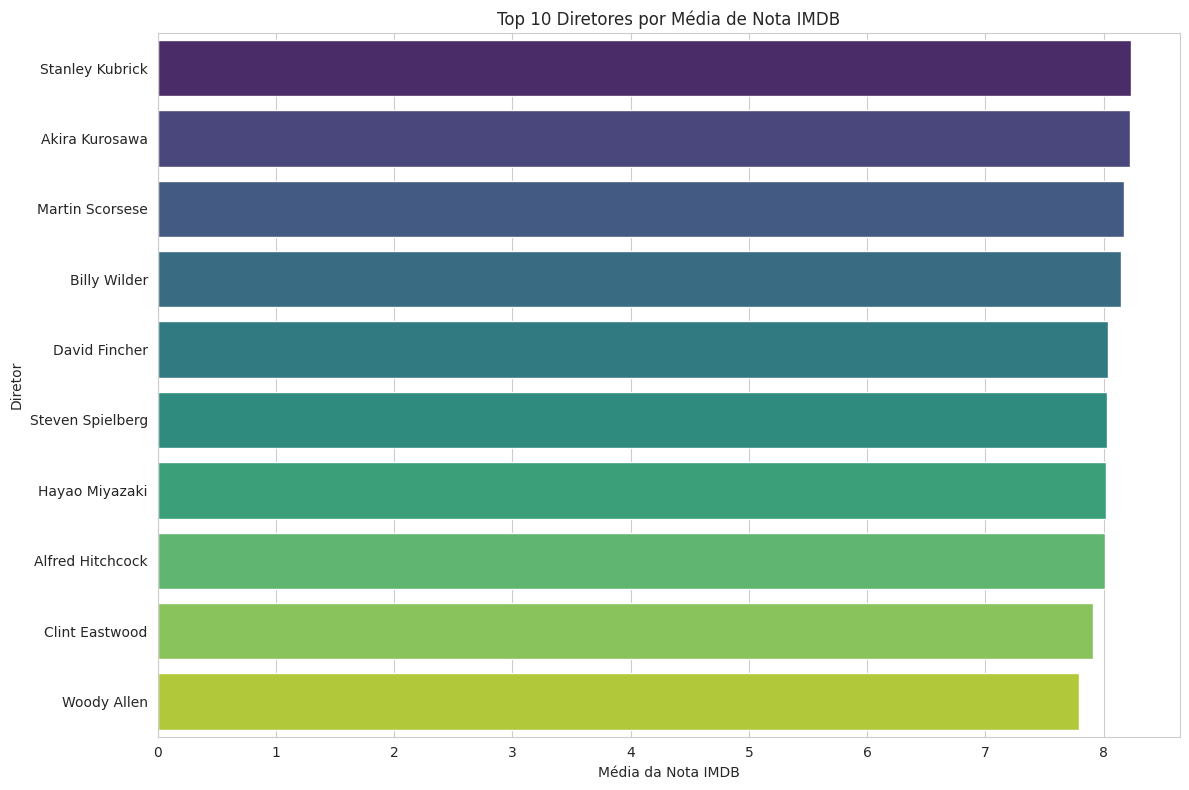

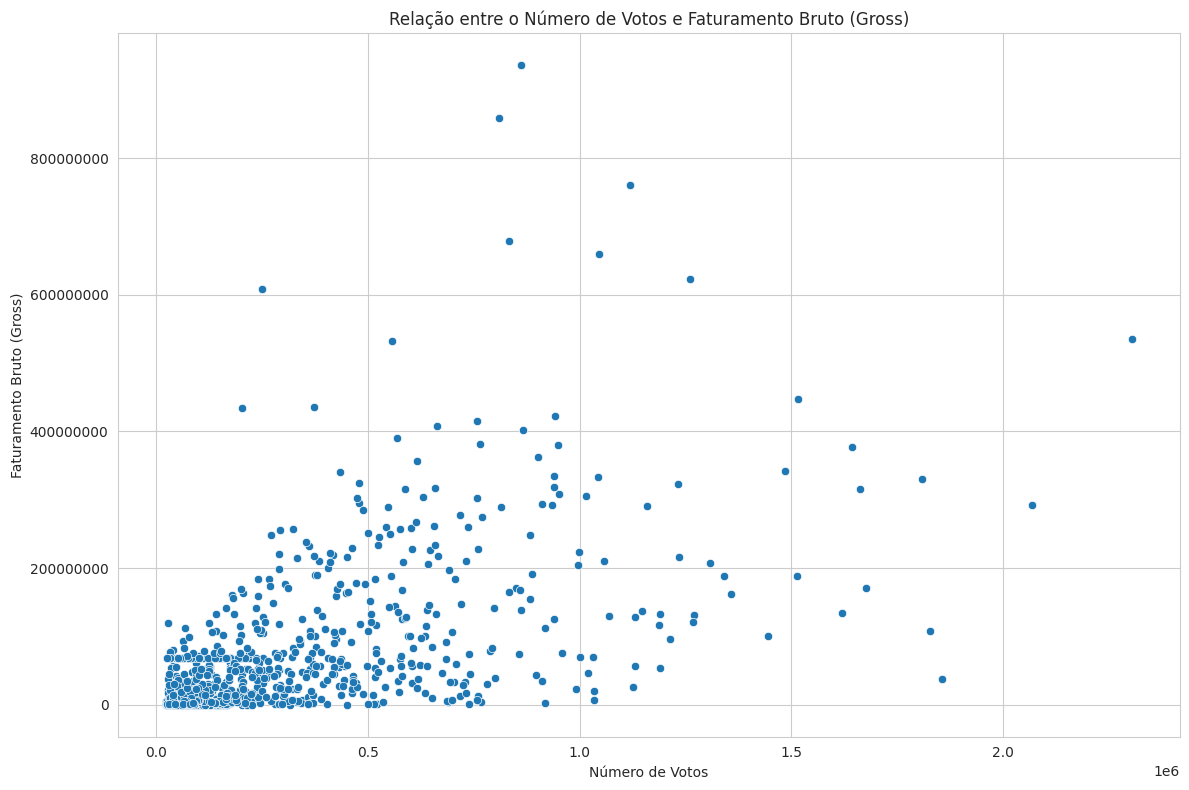

In [299]:
director_ratings = df_top_directors.groupby('Director')['IMDB_Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=director_ratings.values, y=director_ratings.index, palette='viridis')
plt.title('Top 10 Diretores por Média de Nota IMDB')
plt.xlabel('Média da Nota IMDB')
plt.ylabel('Diretor')
plt.tight_layout()
plt.savefig('top_10_directors_by_rating.png')

plt.figure(figsize=(12, 8))
sns.scatterplot(x='No_of_Votes', y='Gross', data=df)
plt.title('Relação entre o Número de Votos e Faturamento Bruto (Gross)')
plt.xlabel('Número de Votos')
plt.ylabel('Faturamento Bruto (Gross)')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.savefig('votes_vs_gross_scatterplot.png')

O primeiro gráfico se trata dos top 10 diretores por média de nota IMDB, ele mostra que os diretores que possuem uma reputação positiva, tendem a possuir maior nota de IMDB.

Já o segundo gráfico mostra que, os filmes com maior número de voto possuem maior faturamento.

Resumo, um filme de sucesso possui muitos votos e é geralmente dirigido por um diretor de alto nível.

Vamos gerar mais dados!

/tmp/ipython-input-1016661836.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=star_gross.values, y=star_gross.index, palette='coolwarm')


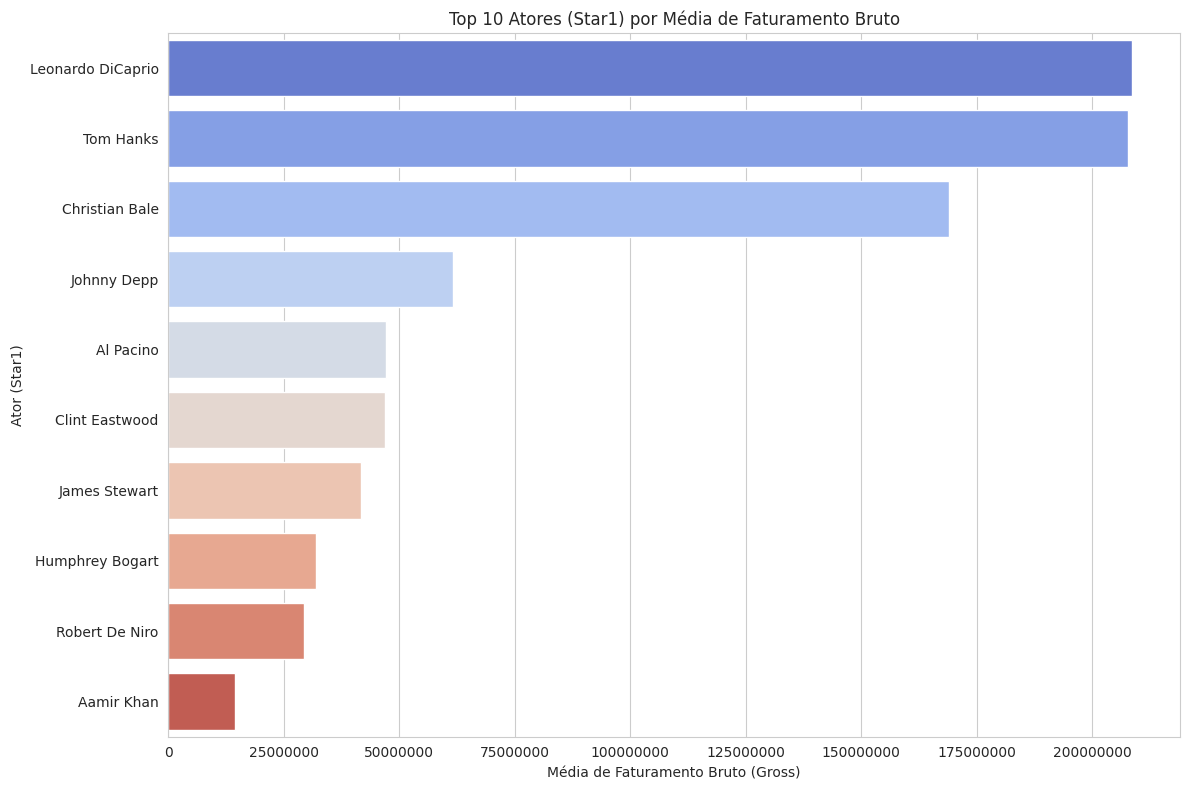

In [300]:
top_stars = df['Star1'].value_counts().head(10).index
top_stars_df = df[df['Star1'].isin(top_stars)]
star_gross = top_stars_df.groupby('Star1')['Gross'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=star_gross.values, y=star_gross.index, palette='coolwarm')
plt.title('Top 10 Atores (Star1) por Média de Faturamento Bruto')
plt.xlabel('Média de Faturamento Bruto (Gross)')
plt.ylabel('Ator (Star1)')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('top_10_stars_by_gross.png')


Com esse gráfico, podemos filtrar os top 10 atores que mais estão frequentes na coluna Star1, e também a média de lucro por eles. Assim, podemos enxergar que, os atores mais frequentes pussem maior lucro. O que também é outro fator importante na análise.

Vamos continuar! O último gráfico será sobre Gênero, mas antes, precisamos tratar essas informações.

/tmp/ipython-input-1787397424.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='crest')
/tmp/ipython-input-1787397424.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_votes.values, y=genre_votes.index, palette='magma')


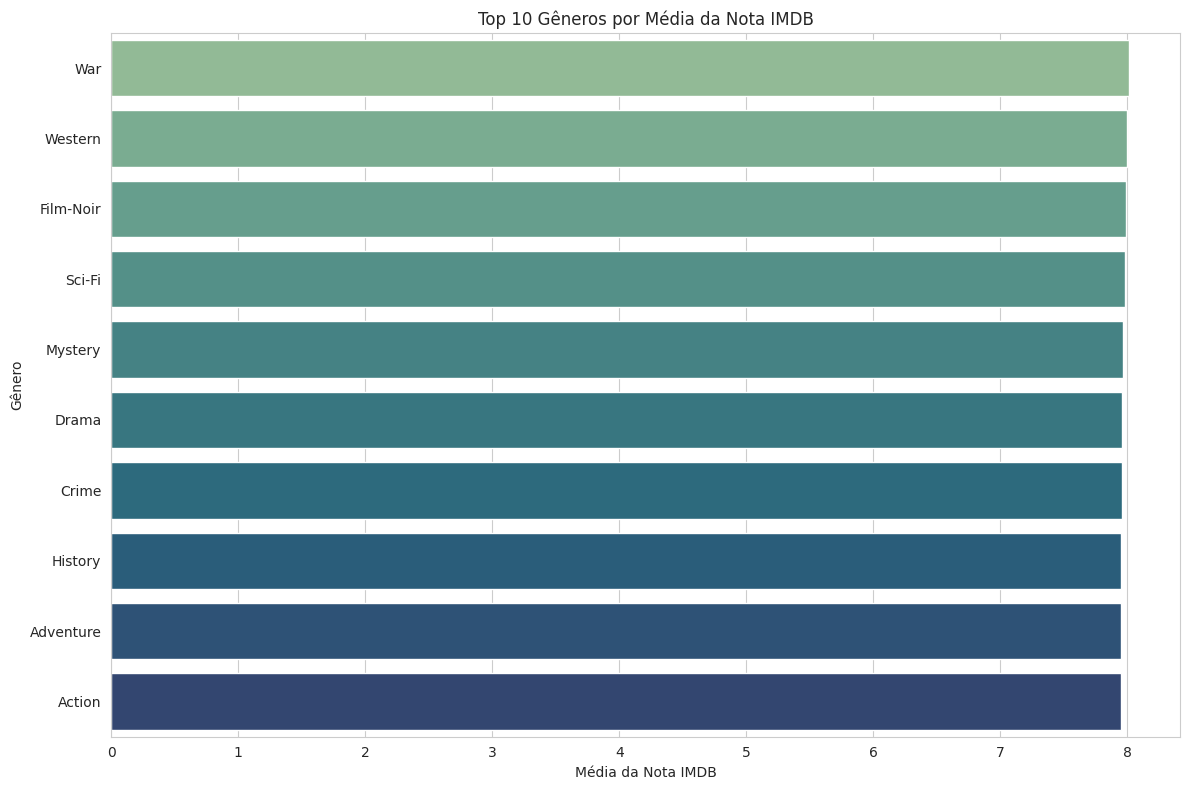

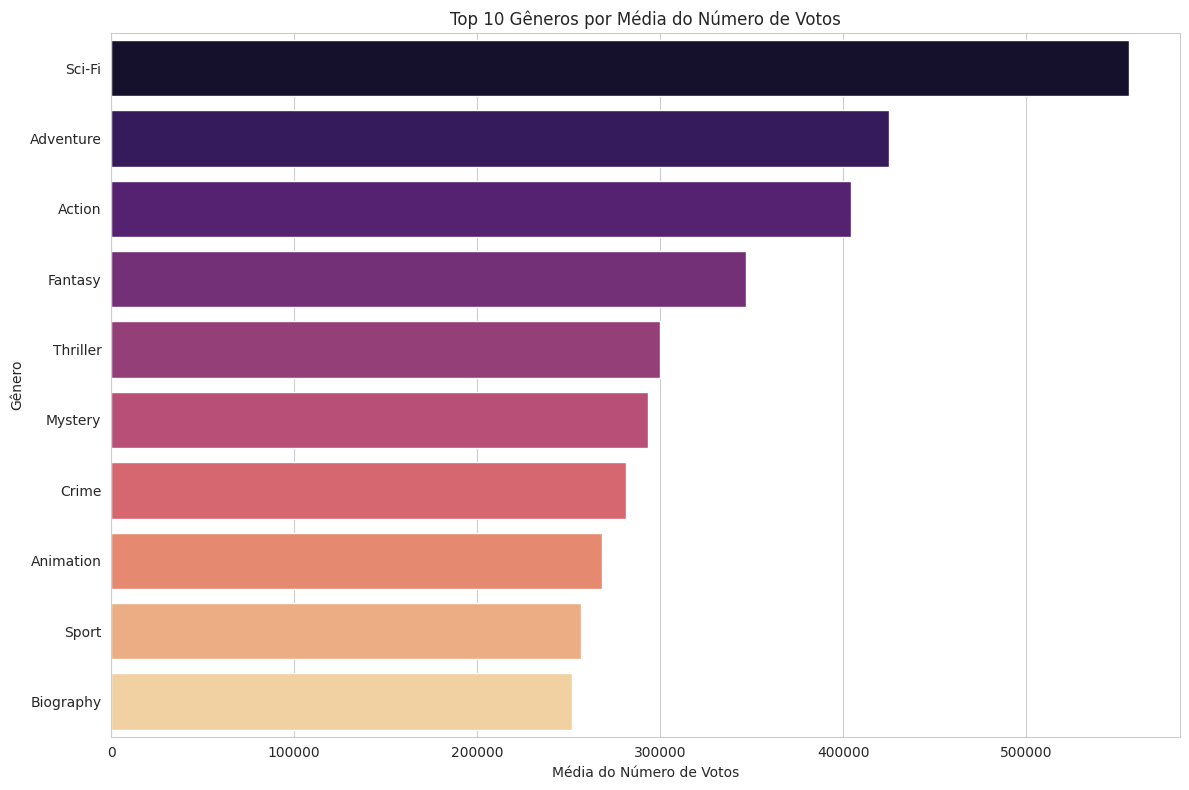

In [301]:

df['Genre'] = df['Genre'].str.split(',')
df_exploded = df.explode('Genre')
df_exploded['Genre'] = df_exploded['Genre'].str.strip()


genre_ratings = df_exploded.groupby('Genre')['IMDB_Rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='crest')
plt.title('Top 10 Gêneros por Média da Nota IMDB')
plt.xlabel('Média da Nota IMDB')
plt.ylabel('Gênero')
plt.tight_layout()
plt.savefig('top_10_genres_by_rating.png')


genre_votes = df_exploded.groupby('Genre')['No_of_Votes'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=genre_votes.values, y=genre_votes.index, palette='magma')
plt.title('Top 10 Gêneros por Média do Número de Votos')
plt.xlabel('Média do Número de Votos')
plt.ylabel('Gênero')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.savefig('top_10_genres_by_votes.png')

O primeiro gráfico de barras, "Top 10 Gêneros por Média da Nota IMDB", revela que os gêneros de filmes Western, Film-Noir e War têm as maiores notas médias. Isso indica que, embora não sejam os gêneros mais comuns, os filmes feitos nessas categorias tendem a ser muito bem avaliados pelo público e pela crítica.

Já o segundo gráfico, "Top 10 Gêneros por Média do Número de Votos", mostra que os gêneros com a maior média de votos são Adventure e Sci-Fi. Isso sugere que filmes de ação e ficção científica, por sua natureza, costumam atrair um público muito maior e gerar mais engajamento. Eles são os blockbusters da lista, com grande apelo de massa, o que se traduz em um número enorme de votos e, provavelmente, em mais discussões e atenção do público.

Em resumo, a análise de gênero mostra que a qualidade não se alinha diretamente com a popularidade. Gêneros de nicho podem ter notas de qualidade muito altas, enquanto os gêneros mais populares, como ação e ficção científica, tendem a dominar o engajamento do público.

Agora, para responder a seguinte pergunta: Qual filme você recomendaria para uma pessoa que você não conhece?

1.   Eu recomendaria um filme que possui alta nota de IMBD, mas também do gênero de maior número de votos: Sci-Fi, Western.

Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

2.   Com base nos gráficos, eu diria que a alta expectativa de faturamento está diretamente ligada a estrela envolvida na trama, ao diretor e também ao gênero do filme.

Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

3.  A coluna Overview é como se fosse um resumo do filme, ela apresenta as características do filme, o que pode incluir bastante palavras chave.  Então poderíamos analisar quais são os termos mais frequentes na coluna, e a partir daí tentar inferir o gênero. Por exemplo, um filme drama pode conter informações sensíveis no overview, como: Perda de algum ente querido, sofrimento de forma geral. Já um filme de aventura, pode conter termos como Parkour, sair busca ao tesouro, etc. Um modelo de aprendizado de máquina como um classificador de texto poderia aprender esses termos, e partir disso, determinar qual é o gênero em questão.


Explique como você faria a previsão da nota do imdb a partir dos dados

4. Para realizar essa previsão, utilizaríamos o modelo de regressão, pois quando estamos tentando prever um dado número, utilizamos esse modelo, diferentemente do de classificação, que é quando estamos tentando prever uma categoria.

Precisaríamos seguir o seguinte processo:

Escolher os dados corretos, como por exemplo o número de votos e a nota da crítica, que são dados relevantes e como vimos nos gráficos, conversam entre si e possuem relação com a nota do IMDB, e também as colunas de ator e diretor, pois como vimos, esses dois parâmetros juntos, também trazem consigo uma boa nota no IMDB.

Preparar os dados: Também é necessário realizar o tratamento dos dados, por exemplo: Ator e gênero são textos, então precisamos transformar esses dois dados em um formato que o modelo compreenda.

Escolher o modelo: Aqui está a chave principal, precisamos escolher o modelo ideal: Árvore de Decisão ou Random Forest. O Random Forest é é mais completo, então traria resultados mais precisos.

Análise de Resultado: Para saber se a nossa previsão é boa, a gente usaria uma medida chamada Erro Absoluto Médio (MAE). Ele nos diz, em média, o quão longe a nossa previsão ficou da nota real, o que é uma forma bem simples de entender a performance do modelo.



Certo, agora que já realizamos todas as análises possíveis, vamos colocar em prática a predição do IMDB do modelo de filme em questão:

* {'Series_Title': 'The Shawshank Redemption',
 * 'Released_Year': '1994',
*  'Certificate': 'A',
 * 'Runtime': '142 min',
 * 'Genre': 'Drama',
*  'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 * 'Meta_score': 80.0,
 * 'Director': 'Frank Darabont',
 * 'Star1': 'Tim Robbins',
 * 'Star2': 'Morgan Freeman',
 * 'Star3': 'Bob Gunton',
*  'Star4': 'William Sadler',
 * 'No_of_Votes': 2343110,
 * 'Gross': '28,341,469'}




In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    999 non-null    object 
 4   Runtime        999 non-null    int64  
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     999 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          999 non-null    float64
dtypes: float64(3), int64(3), object(10)
memory usage: 125.0+ KB


In [303]:
df = preprocess_movies_basic(df)
X = df.drop(columns=["IMDB_Rating","Series_Title","Overview","Unnamed: 0"])
y = df["IMDB_Rating"]
X, mlb = process_genre(X, fit_mlb=True)



In [304]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = ["Director", "Star1", "Star2", "Star3", "Star4", "Certificate", "Released_Year"]
num_features = ["Runtime","No_of_Votes","Gross","Meta_score"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num","passthrough", num_features)
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
])

In [305]:

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Director', 'Star1', 'Star2',
                                                   'Star3', 'Star4',
                                                   'Certificate',
                                                   'Released_Year']),
                                                 ('num', 'passthrough',
                                                  ['Runtime', 'No_of_Votes',
                                                   'Gross', 'Meta_score'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [306]:
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.15688000000000016
RMSE: 0.203431044828463
R²: 0.3695662969959158


In [307]:


new_movie_input = {

    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'


}


In [308]:
new_movie = pd.DataFrame([new_movie_input])
new_movie = preprocess_movies_basic(new_movie)
new_movie, _ = process_genre(new_movie, mlb=mlb, fit_mlb=False)
new_movie = new_movie.reindex(columns=X.columns, fill_value=0)

pred = model.predict(new_movie)[0]
print(f"Nota IMDB: {pred:.2f}")

Nota IMDB: 8.76


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Drama'] will be ignored
  warnings.warn(


In [309]:
joblib.dump(model, "imdb_model.pkl")
print("Modelo salvo em imdb_model.pkl")

Modelo salvo em imdb_model.pkl
